 # Import Libraries


In [93]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Ensure plots are displayed inline in the notebook
%matplotlib inline

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


# Load the Dataset


In [122]:
columns = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2',
           'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]

Load datasets

In [123]:
train_data = pd.read_csv('train_FD004.txt', sep=' ', header=None, names=columns)
test_data = pd.read_csv('test_FD004.txt', sep=' ', header=None, names=columns)
rul_data = pd.read_csv('RUL_FD004.txt', header=None, names=['RUL'])

Clean extra columns caused by space separators

In [124]:
train_data = train_data.dropna(axis=1)
test_data = test_data.dropna(axis=1)

# Quick inspection
print(train_data.head())
print(train_data.info())




     unit_number  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
1 1      42.0049          0.8400         100.0        445.00        549.68   
  2      20.0020          0.7002         100.0        491.19        606.07   
  3      42.0038          0.8409         100.0        445.00        548.95   
  4      42.0000          0.8400         100.0        445.00        548.70   
  5      25.0063          0.6207          60.0        462.54        536.10   

     sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_10  \
1 1   1343.43   1112.93      3.91      5.70    137.36  ...     129.78   
  2   1477.61   1237.50      9.35     13.61    332.10  ...     312.59   
  3   1343.12   1117.05      3.91      5.69    138.18  ...     129.62   
  4   1341.24   1118.03      3.91      5.70    137.98  ...     129.80   
  5   1255.23   1033.59      7.05      9.00    174.82  ...     164.11   

     sensor_11  sensor_12  sensor_13  sensor_14  sensor_15  sensor_16  \
1 1    2387.99    8

### **Understand the Data**

1.  **Columns and Features**:

    -   The dataset includes:
        -   **Unit Number**: Identifies each engine.
        -   **Time in Cycles**: Operational cycles.
        -   **Operational Settings (1, 2, 3)**: Parameters that affect engine performance.
        -   **Sensor Measurements (1 to 26)**: Monitor engine behavior.

    **Reasoning**:

    -   **Unit Number**: Useful for grouping and analyzing per-engine performance.
    -   **Time in Cycles**: Critical for calculating Remaining Useful Life (RUL).
    -   **Operational Settings**: Influence sensor readings and engine performance.
    -   **Sensor Measurements**: Reflect system health and faults.
2.  Goal:

    -   Predict Remaining Useful Life (RUL).
    -   Determine which features contribute most to accurate predictions.


# Data Quality Checks

unit_number       0
time_in_cycles    0
op_setting_1      0
op_setting_2      0
op_setting_3      0
sensor_1          0
sensor_2          0
sensor_3          0
sensor_4          0
sensor_5          0
sensor_6          0
sensor_7          0
sensor_8          0
sensor_9          0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_15         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
dtype: int64
0

Plotting histograms for operational settings...


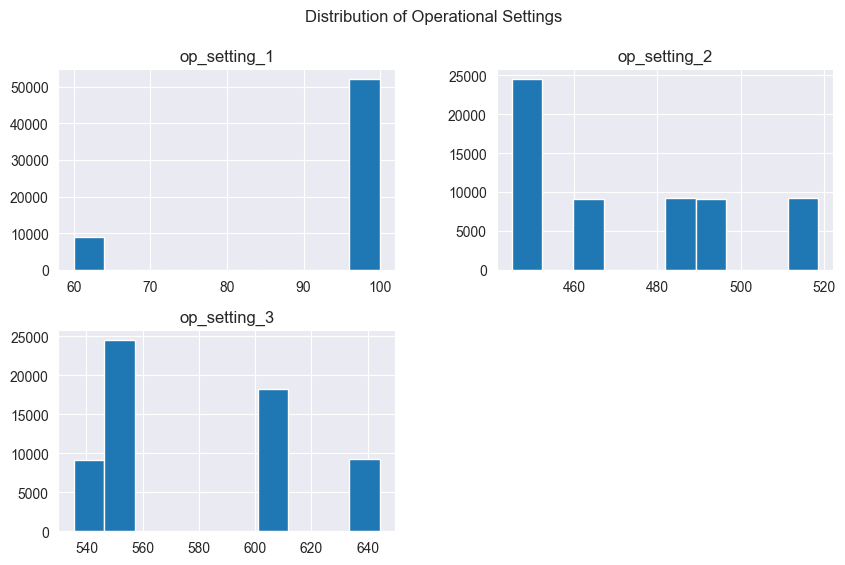

In [125]:
"Checking for missing values..."
print(train_data.isnull().sum())  # Check for missing values in each column
"Checking for duplicate entries..."
print(train_data.duplicated().sum())  # Check for duplicate rows

"Plot histograms for operational settings"
print("\nPlotting histograms for operational settings...")
train_data[['op_setting_1', 'op_setting_2', 'op_setting_3']].hist(figsize=(10, 6))
plt.suptitle('Distribution of Operational Settings')
plt.show()

#  Analyze Sensor Relevance


**Code Example**:



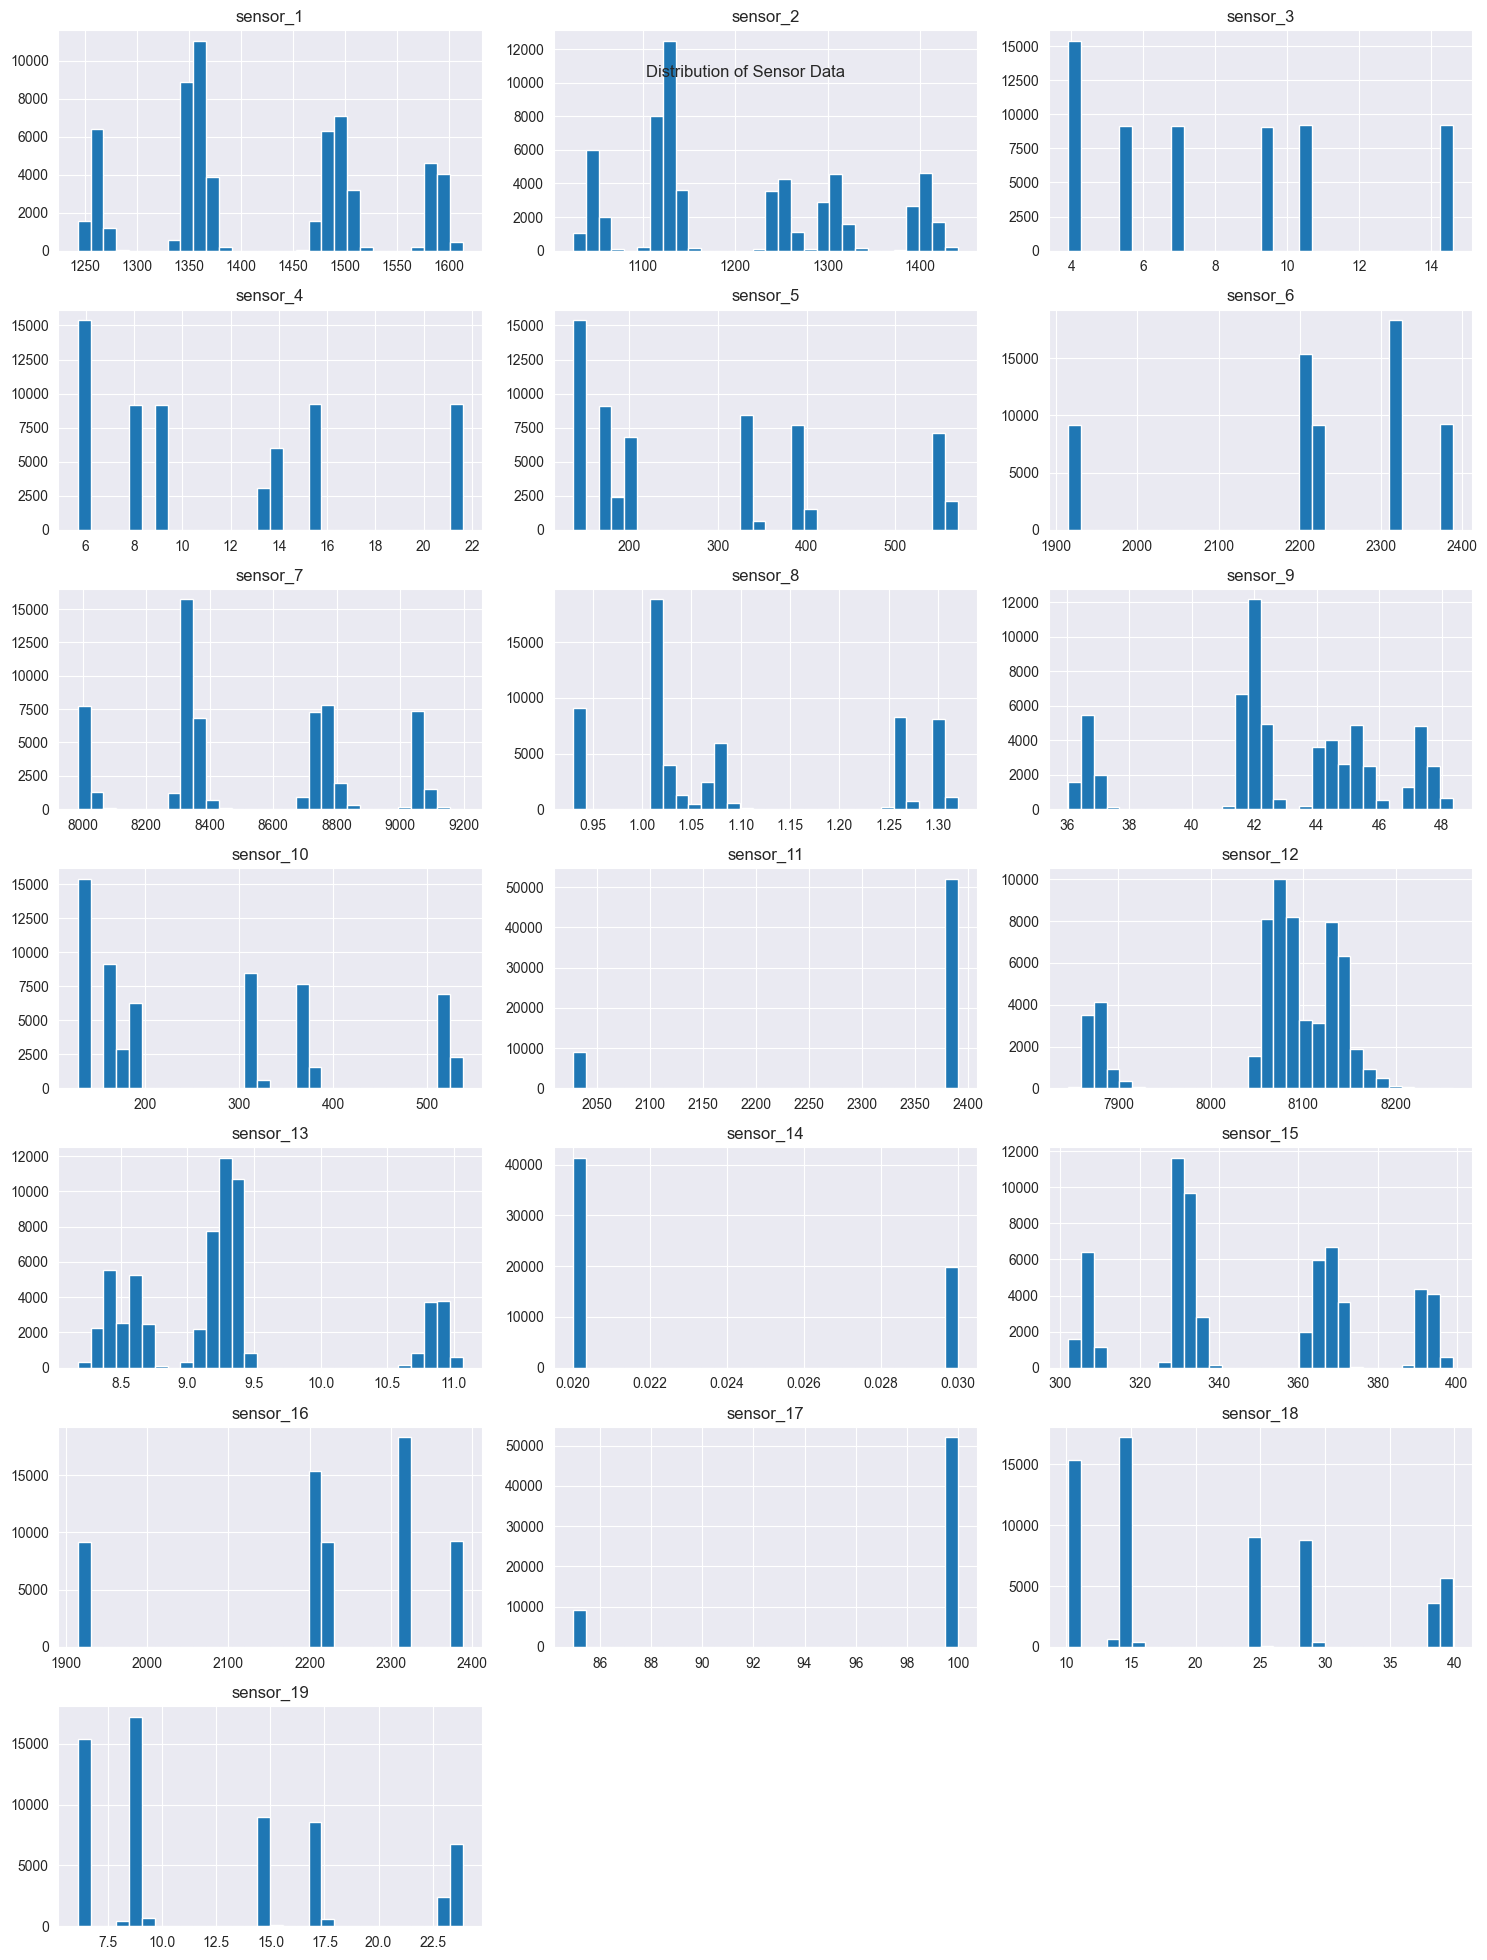

In [126]:
# Visualize sensor data distribution
sensor_columns = [f'sensor_{i}' for i in range(1, 20)]
# Plot histograms for all sensor columns
train_data[sensor_columns].hist(figsize=(15, 20), bins=30, layout=(7, 3))
plt.title('histograms for all sensor columns')
plt.suptitle('Distribution of Sensor Data', y=0.95)
plt.tight_layout()
plt.show()

- Check Sensor Variance

  **Check Variance Across Sensors**:

-   Sensors with very low variance are likely uninformative.
- **Explanation**:

    -   Low-variance sensors don't differentiate between engine states and can be excluded.-   **Correlation Analysis**:

    -   Compute correlations of sensors with RUL.

    **Code Example**:


Calculating sensor variances...
sensor_1      11271.558809
sensor_2      14239.073899
sensor_3         13.125202
sensor_4         29.637316
sensor_5      21573.795950
sensor_6      21126.111710
sensor_7     113520.171620
sensor_8          0.016302
sensor_9         10.520237
sensor_10     19176.463675
sensor_11     16434.691116
sensor_12      7339.442015
sensor_13         0.563061
sensor_14         0.000022
sensor_15       773.300629
sensor_16     21162.245693
sensor_17        28.830710
sensor_18        98.731968
sensor_19        35.553759
dtype: float64


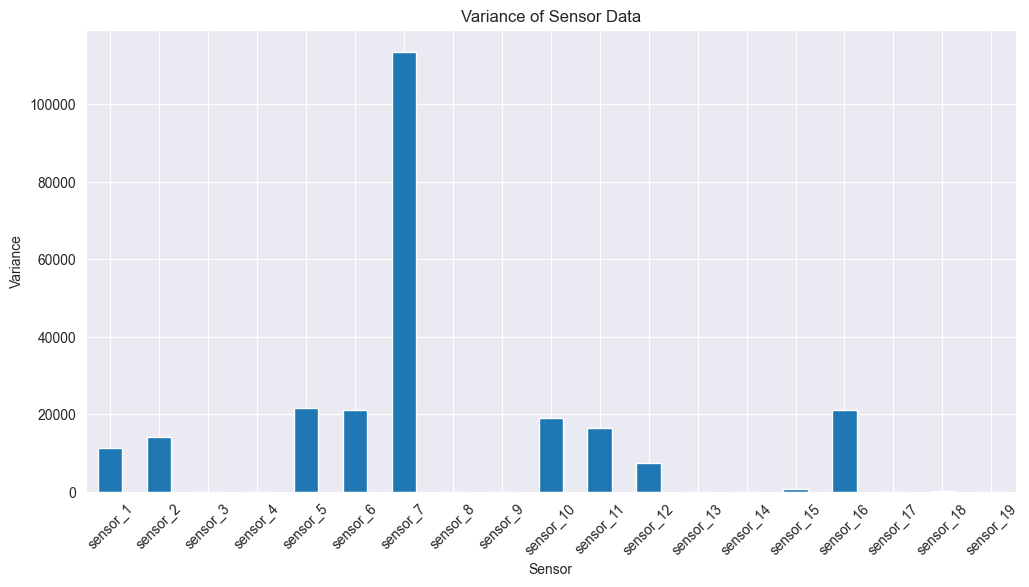

In [128]:
# Calculate variance of each sensor
print("\nCalculating sensor variances...")
sensor_variances = train_data[sensor_columns].var()
print(sensor_variances)

# Visualize variance for better understanding
plt.figure(figsize=(12, 6))
sensor_variances.plot(kind='bar', title='Variance of Sensor Data')
plt.ylabel('Variance')
plt.xlabel('Sensor')
plt.xticks(rotation=45)
plt.show()

## Drop Low-Variance Sensors

In [129]:
# Drop sensors with near-zero variance
threshold = 0.01  # Define a threshold for variance
low_variance_sensors = sensor_variances[sensor_variances < threshold].index.tolist()
print(f"Sensors with variance below {threshold}: {low_variance_sensors}")

# Drop these sensors
train_data.drop(columns=low_variance_sensors, inplace=True)
print(f"\nRemaining columns after dropping low-variance sensors: {train_data.columns.tolist()}")


Sensors with variance below 0.01: ['sensor_14']

Remaining columns after dropping low-variance sensors: ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19']


## Add Remaining Useful Life (RUL)
**Purpose of Training Data**:

-   The training dataset already includes the full run-to-failure cycles for each engine.
-   We compute the Remaining Useful Life (RUL) during preprocessing by calculating the difference between the maximum cycle number and the current cycle. This derived RUL is used as the target variable (`y`) for training.


In [113]:
# # Calculate RUL for the training data
# max_cycle = train_data.groupby('unit_number')['time_in_cycles'].max()
# # print("___>>>>>____")
# # print(max_cycle)
# train_data = train_data.merge(max_cycle, on='unit_number', suffixes=('', '_max'))
# train_data['RUL'] = train_data['time_in_cycles_max'] - train_data['time_in_cycles']
# train_data.drop('time_in_cycles_max', axis=1, inplace=True)
#
# print("\nRUL column added to the training data!")
# print(train_data.head())


RUL column added to the training data!
   unit_number  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
0      42.0049          0.8400         100.0        445.00        549.68   
1      20.0020          0.7002         100.0        491.19        606.07   
2      42.0038          0.8409         100.0        445.00        548.95   
3      42.0000          0.8400         100.0        445.00        548.70   
4      25.0063          0.6207          60.0        462.54        536.10   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_10  \
0   1343.43   1112.93      3.91      5.70    137.36  ...     129.78   
1   1477.61   1237.50      9.35     13.61    332.10  ...     312.59   
2   1343.12   1117.05      3.91      5.69    138.18  ...     129.62   
3   1341.24   1118.03      3.91      5.70    137.98  ...     129.80   
4   1255.23   1033.59      7.05      9.00    174.82  ...     164.11   

   sensor_11  sensor_12  sensor_13  sensor_15  sensor_16  sensor_17  \
0    

# Correlation Analysis

In [130]:
# Correlation analysis to identify relevant features
print("\nCalculating correlations with RUL...")
correlation_matrix = train_data.corr()
correlation_with_rul = correlation_matrix['RUL'].sort_values()

# Display correlations
print(correlation_with_rul)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()



Calculating correlations with RUL...


KeyError: 'RUL'

KeyError: 'RUL'

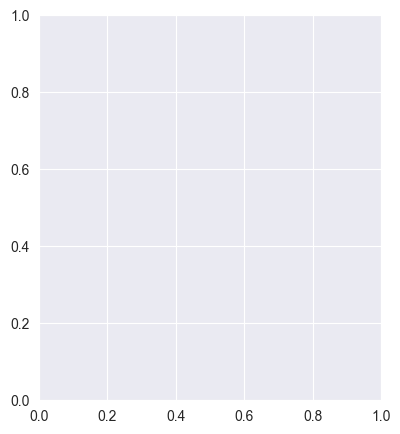

In [131]:
# Plot operational settings vs. RUL
plt.figure(figsize=(15, 5))
for i, setting in enumerate(['op_setting_1', 'op_setting_2', 'op_setting_3'], 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=train_data[setting], y=train_data['RUL'], alpha=0.5)
    plt.title(f'{setting} vs. RUL')
    plt.xlabel(setting)
    plt.ylabel('RUL (Cycles)')
plt.tight_layout()
plt.show()

## Save Preprocessed Data

In [17]:
# Save the cleaned and preprocessed data for future use
output_file_path = 'D:\SRH\SEM 3\Modeling Simulation Notes & Project\Modeling Simulation Project\DATASET\preprocessed_train_data.csv'  # Replace with your desired path
train_data.to_csv(output_file_path, index=False)

print(f"Preprocessed data saved to {output_file_path}")

Preprocessed data saved to D:\SRH\SEM 3\Modeling Simulation Notes & Project\Modeling Simulation Project\DATASET\preprocessed_train_data.csv


### Freature Selection and Train data set

In [136]:
# Calculate max cycle for each engine
max_cycle = train_data.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycle.columns = ['unit_number', 'max_cycle']

# Merge with training data and compute RUL
train_data = train_data.merge(max_cycle, on='unit_number')
train_data['RUL'] = train_data['max_cycle'] - train_data['time_in_cycles']
train_data.drop('max_cycle', axis=1, inplace=True)

print("\nCorrected RUL calculation:")
print(train_data[['unit_number', 'time_in_cycles', 'RUL']].head())

# Feature list (exclude 'unit_number' and 'RUL' during normalization)
selected_features = [
    'time_in_cycles',  # Use original cycles for modeling
    'op_setting_1', 'op_setting_2', 'op_setting_3',
    'sensor_1', 'sensor_2', 'sensor_6', 'sensor_7', 'sensor_9',
    'sensor_11', 'sensor_12', 'sensor_15', 'sensor_16', 'sensor_17'
]  # Add your features

# Initialize scaler
scaler = MinMaxScaler()

# Normalize selected features
train_data_scaled = train_data.copy()
train_data_scaled[selected_features] = scaler.fit_transform(train_data[selected_features])

# Retain 'unit_number' and 'RUL' without normalization
train_data_scaled['unit_number'] = train_data['unit_number']
train_data_scaled['RUL'] = train_data['RUL']

print("\nNormalized data with valid RUL:")
print(train_data_scaled.head())




Corrected RUL calculation:
   unit_number  time_in_cycles     RUL
0      42.0049          0.8400  0.0020
1      20.0020          0.7002  0.0018
2      42.0038          0.8409  0.0011
3      42.0000          0.8400  0.0020
4      25.0063          0.6207  0.0012

Normalized data with valid RUL:
   unit_number  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
0      42.0049        0.997625           1.0      0.000000      0.130347   
1      20.0020        0.831591           1.0      0.626985      0.647971   
2      42.0038        0.998694           1.0      0.000000      0.123646   
3      42.0000        0.997625           1.0      0.000000      0.121351   
4      25.0063        0.737173           0.0      0.238089      0.005691   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_10  \
0  0.272082  0.212586      3.91      5.70    137.36  ...     129.78   
1  0.634407  0.511781      9.35     13.61    332.10  ...     312.59   
2  0.271245  0.222481      3.91    

### Process Test Data

In [117]:
# Feature selection
selected_features = [
    'op_setting_1', 'op_setting_2', 'op_setting_3',
    'sensor_1', 'sensor_2', 'sensor_6', 'sensor_7', 'sensor_9',
    'sensor_11', 'sensor_12', 'sensor_15', 'sensor_16', 'sensor_17'
]

# Extract the last cycle for each unit in the test data
last_cycle_data = test_data.groupby('unit_number').last().reset_index()
#
# Merge the last cycle data with the RUL data
test_data_processed = last_cycle_data.merge(rul_data, left_on='unit_number', right_index=True)

# Normalize only the selected columns
columns_to_normalize = selected_features + ['time_in_cycles']
scaler = MinMaxScaler()

test_data_normalized = test_data_processed.copy()  # Avoid modifying the original
test_data_normalized[columns_to_normalize] = scaler.fit_transform(test_data_processed[columns_to_normalize])

# Ensure `unit_number` is preserved and `RUL` is properly merged
test_data_normalized['unit_number'] = test_data_processed['unit_number']
test_data_normalized['RUL'] = test_data_processed['RUL']

# Print corrected test data
print("\nCorrected: Test data normalized and merged with true RUL values!")
print(test_data_normalized.head())

# Save the processed data
train_data_scaled.to_csv('preprocessed_train_data.csv', index=False)
test_data_normalized.to_csv('preprocessed_test_data.csv', index=False)

print("Preprocessed data saved successfully!")





Corrected: Test data normalized and merged with true RUL values!
     unit_number  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
0            0.0        0.000000           1.0      1.000000      1.000000   
51          10.0        0.297619           1.0      0.597937      0.637881   
152         20.0        0.833333           1.0      0.626985      0.663010   
253         25.0        0.738095           0.0      0.238089      0.000000   
354         35.0        1.000000           1.0      0.060269      0.174308   

     sensor_1  sensor_2  sensor_6  sensor_7  sensor_9  sensor_11  sensor_12  \
0    1.000000  1.000000   1.00000  1.000000  1.000000   0.999889   1.000000   
51   0.697788  0.688399   0.85338  0.742208  0.785185   0.999944   0.986724   
152  0.666557  0.576948   0.86419  0.681669  0.730556   1.000000   0.671851   
253  0.000000  0.000000   0.00000  0.000000  0.000000   0.000000   0.000000   
354  0.263210  0.183332   0.65030  0.321250  0.436111   0.999444   0.6

PermissionError: [Errno 13] Permission denied: 'preprocessed_test_data.csv'

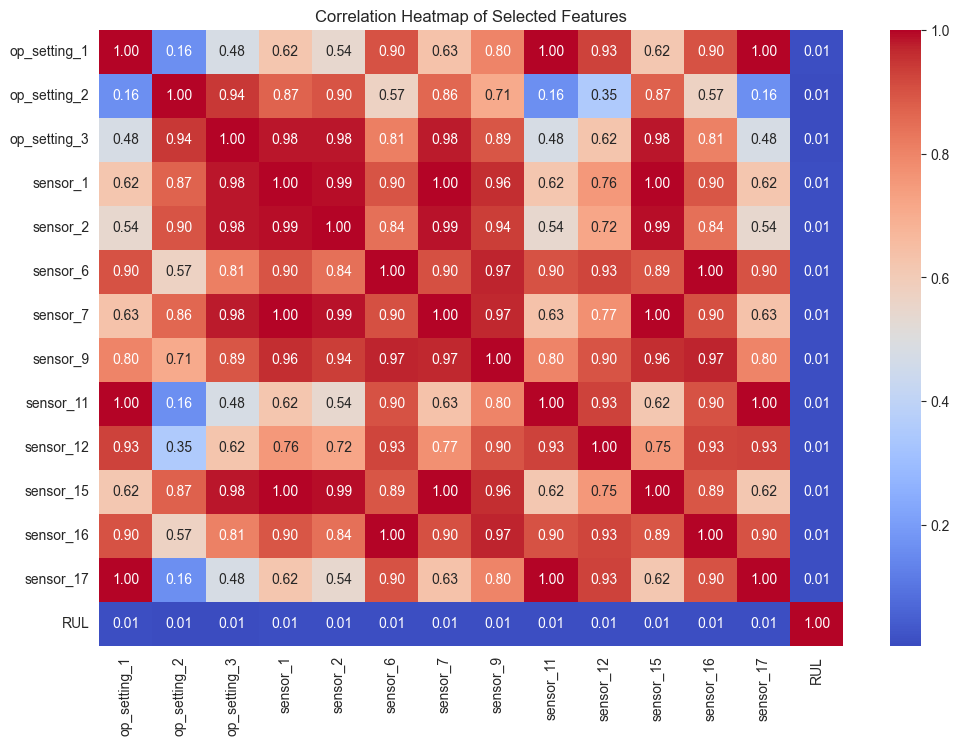

In [118]:
# Plot correlation heatmap for selected features
selected_features_corr = train_data[selected_features + ['RUL']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(selected_features_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Selected Features')
plt.show()

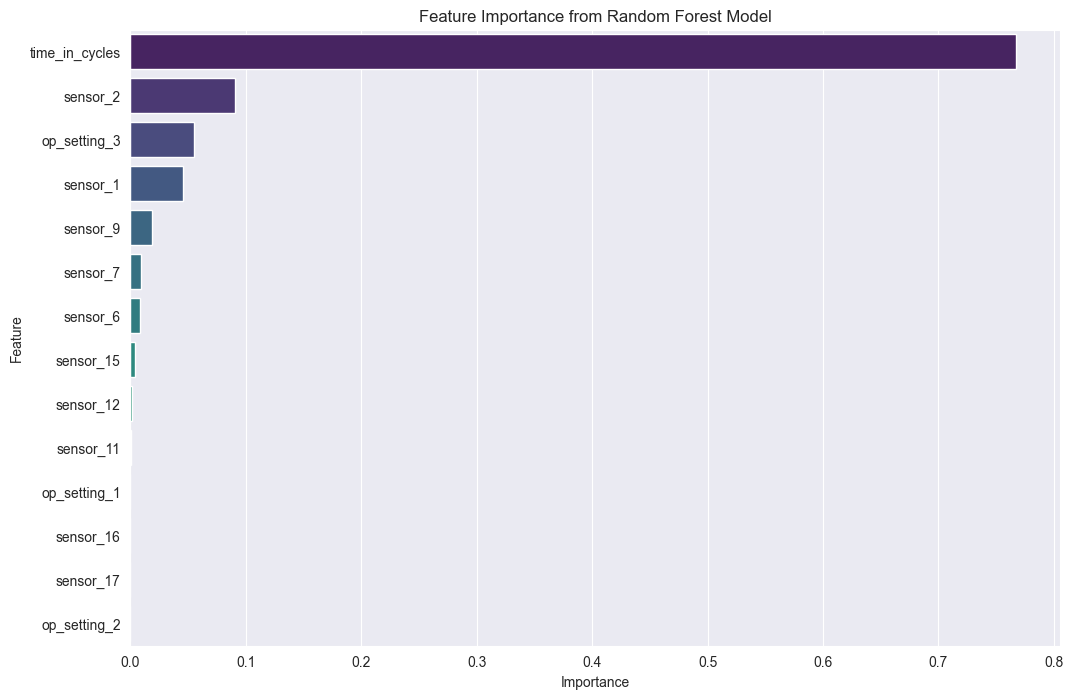

In [119]:
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

##  Random Forest

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split the data into features and target
X = train_data_scaled.drop(columns=['unit_number', 'RUL'])
y = train_data_scaled['RUL']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

# Feature importance
importances = rf_regressor.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

Mean Squared Error: 2.2766417142852523e-09
Mean Absolute Error: 3.552824489795541e-05
R^2 Score: 0.9946064438934044
           Feature  Importance
0   time_in_cycles    0.767248
5         sensor_2    0.090281
3     op_setting_3    0.054715
4         sensor_1    0.045343
8         sensor_9    0.018724
7         sensor_7    0.009612
6         sensor_6    0.008031
11       sensor_15    0.004010
10       sensor_12    0.001606
9        sensor_11    0.000414
1     op_setting_1    0.000007
12       sensor_16    0.000006
13       sensor_17    0.000002
2     op_setting_2    0.000002


In [41]:
from tabulate import tabulate

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create a table
metrics_table = [
    ["Mean Squared Error (MSE)", mse],
    ["Mean Absolute Error (MAE)", mae],
    ["R² Score", r2]
]

# Display the table
print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="pretty"))

+---------------------------+------------------------+
|          Metric           |         Value          |
+---------------------------+------------------------+
| Mean Squared Error (MSE)  | 2.2766417142852523e-09 |
| Mean Absolute Error (MAE) | 3.552824489795541e-05  |
|         R² Score          |   0.9946064438934044   |
+---------------------------+------------------------+


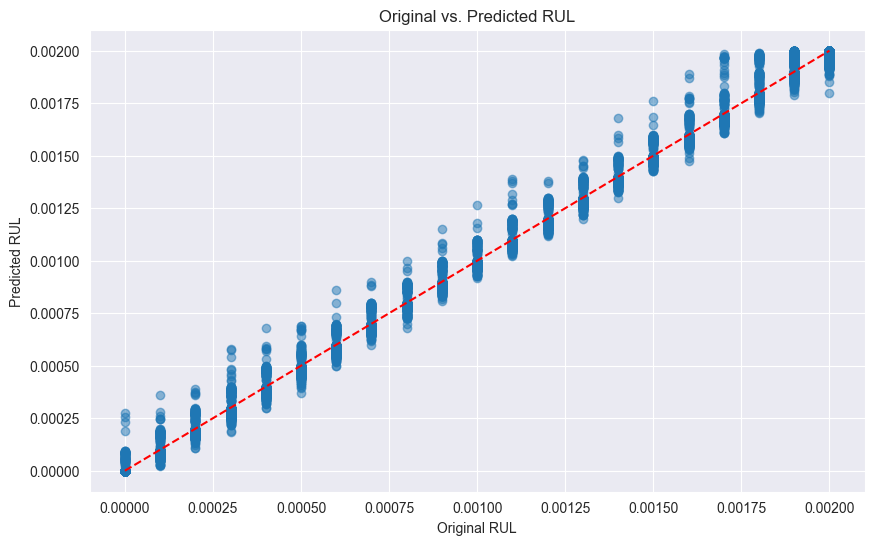

In [22]:
# Plot original vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Original RUL')
plt.ylabel('Predicted RUL')
plt.title('Original vs. Predicted RUL')
plt.grid(True)
plt.show()

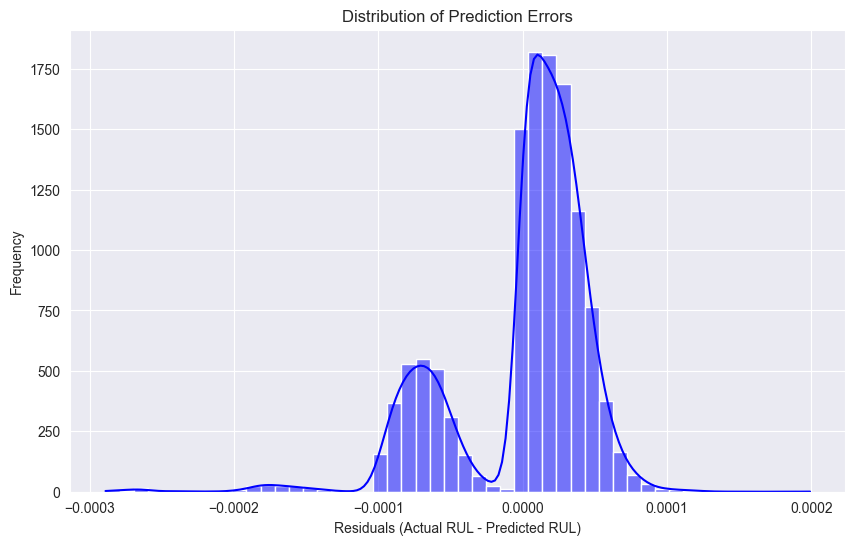

In [39]:
# Plot error distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True, color='blue')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Residuals (Actual RUL - Predicted RUL)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

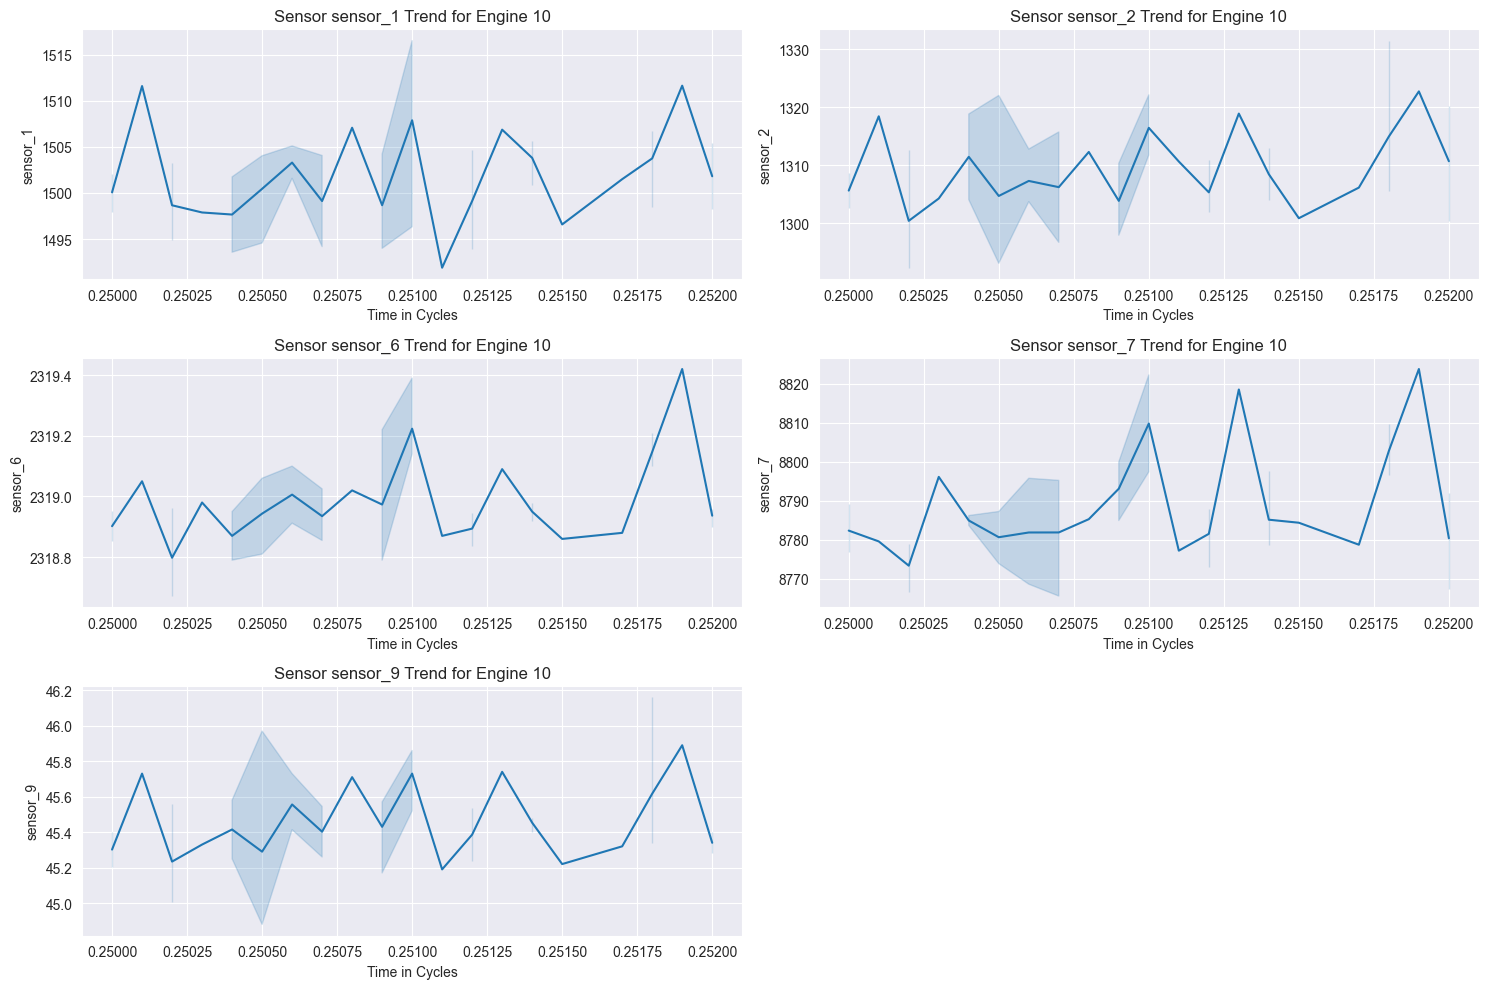

In [82]:
# Plot sensor trends for Engine 1
engine_id =10 #[0,10,20,25,35,42]
engine_data = train_data[train_data['unit_number'] == engine_id]

plt.figure(figsize=(15, 10))
for i, sensor in enumerate(['sensor_1', 'sensor_2', 'sensor_6', 'sensor_7', 'sensor_9'], 1):
    plt.subplot(3, 2, i)
    sns.lineplot(x=engine_data['time_in_cycles'], y=engine_data[sensor])
    plt.title(f'Sensor {sensor} Trend for Engine {engine_id}')
    plt.xlabel('Time in Cycles')
    plt.ylabel(sensor)
plt.tight_layout()
plt.show()

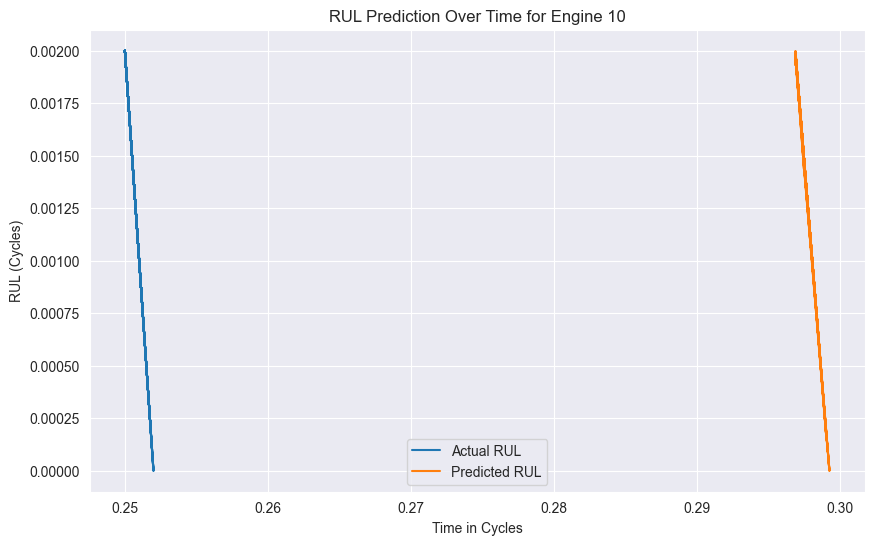

In [83]:
# Predict RUL for Engine
engine_data_scaled = train_data_scaled[train_data_scaled['unit_number'] == engine_id]
engine_data_scaled['Predicted_RUL'] = rf_regressor.predict(engine_data_scaled.drop(columns=['unit_number', 'RUL']))

# Plot actual vs. predicted RUL
plt.figure(figsize=(10, 6))
plt.plot(engine_data['time_in_cycles'], engine_data['RUL'], label='Actual RUL')
plt.plot(engine_data_scaled['time_in_cycles'], engine_data_scaled['Predicted_RUL'], label='Predicted RUL')
plt.title(f'RUL Prediction Over Time for Engine {engine_id}')
plt.xlabel('Time in Cycles')
plt.ylabel('RUL (Cycles)')
plt.legend()
plt.grid(True)
plt.show()

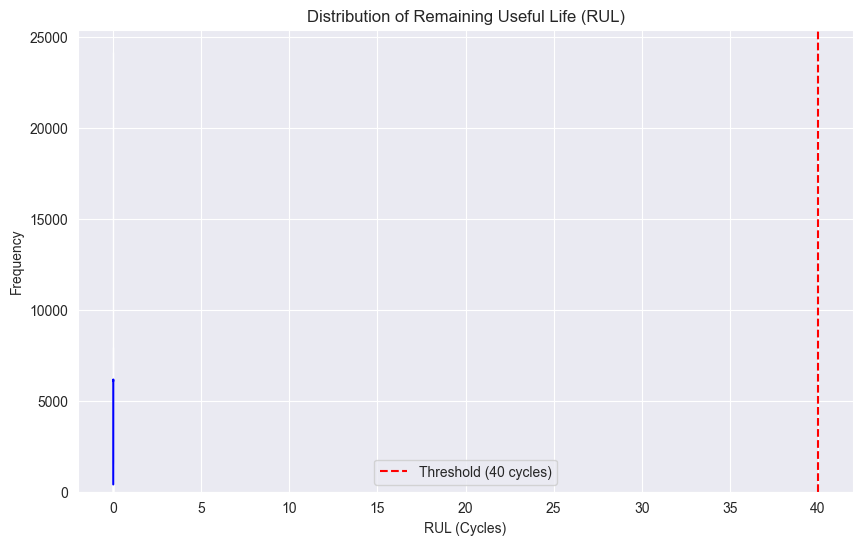

In [81]:
# Plot RUL distribution with threshold
plt.figure(figsize=(10, 6))
sns.histplot(train_data['RUL'], bins=50, kde=True, color='blue')
plt.axvline(x=40, color='red', linestyle='--', label='Threshold (40 cycles)')
plt.title('Distribution of Remaining Useful Life (RUL)')
plt.xlabel('RUL (Cycles)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [90]:
# Calculate RUL for the test data
max_cycle_test = test_data.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycle_test.columns = ['unit_number', 'max_cycle']
test_data = test_data.merge(max_cycle_test, on='unit_number', how='left')
test_data['RUL'] = test_data['max_cycle'] - test_data['time_in_cycles']
test_data.drop(columns=['max_cycle'], inplace=True)

# Extract the last cycle for each engine unit
last_cycle_data = test_data.groupby('unit_number').last().reset_index()

# Evaluate different thresholds
thresholds = [30, 40, 50]
for threshold in thresholds:
    # Apply the threshold to the final RUL values
    last_cycle_data['Failure_Likely'] = last_cycle_data['RUL'] <= threshold

    # Count the number of engines flagged for maintenance
    flagged_engines = last_cycle_data[last_cycle_data['Failure_Likely']]
    percentage_flagged = len(flagged_engines) / len(last_cycle_data) * 100
    print(f"Threshold: {threshold} cycles | Flagged Engines: {percentage_flagged:.2f}%")

    # Example: Check if a specific engine is flagged
    engine_id = 25  # Replace with the engine ID you want to check
    engine_status = last_cycle_data[last_cycle_data['unit_number'] == engine_id]['Failure_Likely'].values[0]
    if engine_status:
        print(f"Engine {engine_id} is likely to fail soon. Schedule maintenance!")
    else:
        print(f"Engine {engine_id} is in good condition.")

Threshold: 30 cycles | Flagged Engines: 100.00%
Engine 25 is likely to fail soon. Schedule maintenance!
Threshold: 40 cycles | Flagged Engines: 100.00%
Engine 25 is likely to fail soon. Schedule maintenance!
Threshold: 50 cycles | Flagged Engines: 100.00%
Engine 25 is likely to fail soon. Schedule maintenance!


##  LSTM (Long Short-Term Memory) Network

In [20]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Reshape the data for LSTM input (samples, timesteps, features)
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].drop(columns=['unit_number', 'RUL']).values
        y = data.iloc[i + seq_length]['RUL']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
seq_length = 30  # You can experiment with different values

# Create sequences for training and testing data
X_train_seq, y_train_seq = create_sequences(train_data_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(test_data_normalized, seq_length)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))  # Additional dense layer
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=20,  # You can increase the number of epochs
    batch_size=32,
    validation_split=0.2,  # Use 20% of the training data for validation
    verbose=1
)

# Evaluate the model on the test data
y_pred_lstm = model.predict(X_test_seq)
mse_lstm = mean_squared_error(y_test_seq, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
r2_lstm = r2_score(y_test_seq, y_pred_lstm)

print(f"LSTM Mean Squared Error: {mse_lstm}")
print(f"LSTM Mean Absolute Error: {mae_lstm}")
print(f"LSTM R^2 Score: {r2_lstm}")

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot original vs. predicted RUL values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_seq, y_pred_lstm, alpha=0.5)
plt.plot([min(y_test_seq), max(y_test_seq)], [min(y_test_seq), max(y_test_seq)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Original RUL')
plt.ylabel('Predicted RUL')
plt.title('Original vs. Predicted RUL')
plt.grid(True)
plt.show()

ModuleNotFoundError: No module named 'tensorflow.python'